In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import argparse
import wandb
import numpy as np
import tensorflow as tf

from img_clf.dataloader import GetDataloader
from img_clf.model import get_model
from img_clf.callbacks import WandbClfEvalCallback

import matplotlib.pyplot as plt

In [ ]:
def get_args():
    parser = argparse.ArgumentParser(description="Train image classification model.")
    parser.add_argument("--batch_size", type=int, default=32, help="batch size for training")
    parser.add_argument("--epochs", type=int, default=10, help="number of epochs for training")
    parser.add_argument("--img_height", type=int, default=224, help="image height for training")
    parser.add_argument("--img_width", type=int, default=224, help="image width for training")
    parser.add_argument("--img_channels", type=int, default=3, help="image channels for training")
    parser.add_argument("--shuffle_buffer_size", type=int, default=1000, help="shuffle buffer size for training")
    parser.add_argument("--wandb_project_name", type=str, default="e2e-img-clf", help="wandb project name")
    parser.add_argument("--model_backbone", type=str, default="resnet50", help="backbone for the model")
    parser.add_argument("--dropout_rate", type=float, default=0.2, help="Dropout rate post GAP")
    parser.add_argument("--num_classes", type=int, default=53, help="Number of classes in the dataset")
    parser.add_argument("--one_hot", type=bool, default=True, help="One hot encode the labels")
    parser.add_argument("--freeze_backbone", type=bool, default=True, help="Freeze the backbone layers")

    return parser.parse_args("")

In [ ]:
args = get_args()
args

In [5]:
# Get the dataloaders
dataloader = GetDataloader(args)
trainloader = dataloader.get_dataloader("train")
validloader = dataloader.get_dataloader("val")

wandb: Downloading large artifact cards_dataset:v1, 153.34MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.3
wandb: Building dataset for split: train...
wandb: Built dataset for split: train, num_shards: 2, num_examples: 7624
wandb: Building dataset for split: val...
wandb: Built dataset for split: val, num_shards: 1, num_examples: 265
wandb: Building dataset for split: test...
wandb: Built dataset for split: test, num_shards: 1, num_examples: 265


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
wandb: Downloading large artifact cards_dataset:v1, 153.34MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.3
wandb: Building dataset for split: train...
wandb: Built dataset for split: train, num_shards: 2, num_examples: 7624
wandb: Building dataset for split: val...
wandb: Built dataset for split: val, num_shards: 1, num_examples: 265
wandb: Building dataset for split: test...
wandb: Built dataset for split: test, num_shards: 1, num_examples: 265


In [6]:
imgs, labels = next(iter(trainloader))

In [7]:
imgs.shape, labels.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 53]))

42


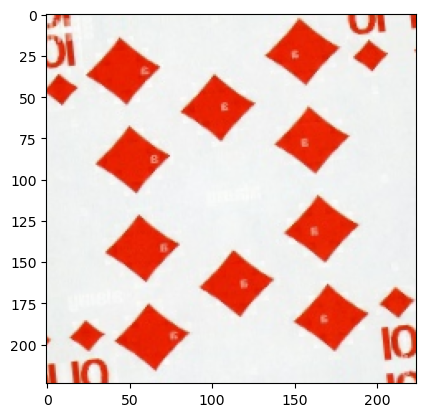

In [8]:
idx = 14
plt.imshow(imgs[idx])
print(np.argmax(labels[idx]))

In [34]:
# Get the model
models = get_model(args)
models.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy() if args.one_hot else tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [11]:
model.fit(
    trainloader,
    epochs=3,
    validation_data=validloader,        
)

Epoch 1/3
239/239 [==============================] - 26s 81ms/step - loss: 3.8096 - accuracy: 0.0682 - val_loss: 3.4086 - val_accuracy: 0.2000
Epoch 2/3
239/239 [==============================] - 18s 73ms/step - loss: 3.4806 - accuracy: 0.1339 - val_loss: 3.0976 - val_accuracy: 0.2868
Epoch 3/3
239/239 [==============================] - 19s 80ms/step - loss: 3.2977 - accuracy: 0.1944 - val_loss: 2.8832 - val_accuracy: 0.3208


In [12]:
val_imgs, val_labels = next(iter(validloader))

In [35]:
from tf_explain.core.grad_cam import GradCAM

In [43]:
explainer = GradCAM()

In [44]:
np.argmax(val_labels[idx])

34

In [47]:
idx = 0

gradcam = explainer.explain(
    validation_data=(tf.expand_dims(val_imgs[idx], axis=0).numpy(), np.argmax(val_labels[idx])),
    model=models,
    class_index=np.argmax(val_labels[idx]),
    layer_name=None,
    use_guided_grads=True,
    colormap=cv2.COLORMAP_VIRIDIS,
    image_weight=0.7,
)

In [17]:
import cv2

In [48]:
gradcam

array([[[248, 182, 255],
        [248, 183, 255],
        [248, 183, 255],
        ...,
        [246, 180, 255],
        [246, 180, 255],
        [246, 180, 255]],

       [[248, 182, 255],
        [248, 182, 255],
        [248, 183, 255],
        ...,
        [246, 180, 255],
        [246, 180, 255],
        [246, 180, 255]],

       [[248, 184, 255],
        [247, 183, 255],
        [248, 183, 255],
        ...,
        [246, 180, 255],
        [246, 180, 255],
        [246, 180, 255]],

       ...,

       [[250, 206, 255],
        [250, 206, 255],
        [250, 206, 255],
        ...,
        [250, 206, 255],
        [250, 206, 255],
        [250, 204, 255]],

       [[250, 206, 255],
        [250, 206, 255],
        [250, 206, 255],
        ...,
        [250, 205, 255],
        [250, 206, 255],
        [250, 206, 255]],

       [[250, 206, 255],
        [250, 206, 255],
        [250, 206, 255],
        ...,
        [250, 206, 255],
        [250, 204, 255],
        [250, 206, 255]]

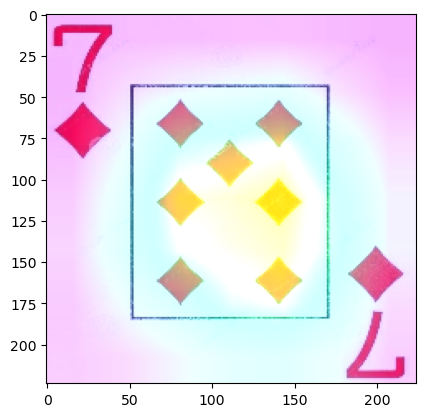

In [49]:
plt.imshow(gradcam)

In [ ]:
# # Initialize wandb
# wandb.init(project=args.wandb_project_name, entity="ml-colabs", config=vars(args))

# # Train the model
# model.fit(
#     trainloader,
#     epochs=args.epochs,
#     validation_data=validloader,
#     callbacks=[
#         wandb.keras.WandbMetricsLogger(log_freq=2),
#         WandbClfEvalCallback(
#             validloader = validloader,
#             data_table_columns = ["idx", "image", "label"],
#             pred_table_columns = ["epoch", "idx", "image", "label", "pred"]
#         )
#     ]
# )

# # Evaluate the model
# eval_loss, eval_acc = model.evaluate(validloader)
# wandb.log({"eval_loss": eval_loss, "eval_acc": eval_acc})